In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('voltage_data.xlsx')


In [3]:
df.head(20)

,Date,Time,Vol Conventinal solar panel,Vol Pure Sisal,Vol Sisal + Jute,Vol Coated sisal,Vol Coated Sisal + Jute
0,02.01.23,09:00:00,8.71,6.25,8.51,8.77,7.91
1,02.01.23,10:00:00,8.36,6.88,8.17,7.11,8.27
2,02.01.23,11:00:00,8.80,7.04,8.86,8.63,8.46
3,02.01.23,12:00:00,8.93,7.25,8.84,9.04,8.87
4,02.01.23,13:00:00,8.96,7.37,8.95,8.94,8.92
5,02.01.23,14:00:00,8.80,7.46,8.87,8.91,8.83
6,02.01.23,15:00:00,8.69,6.71,8.55,8.69,8.59
7,02.01.23,16:00:00,8.02,5.55,7.89,7.95,8.07
8,02.01.23,17:00:00,7.82,5.17,7.92,8.06,8.10
9,03.01.23,09:00:00,8.15,6.78,8.05,8.09,8.12


In [4]:
df.columns=df.columns.str.strip()

In [5]:
df.columns 

Index(['Date', 'Time', 'Vol Conventinal solar panel', 'Vol Pure Sisal',
       'Vol Sisal + Jute', 'Vol Coated sisal', 'Vol Coated Sisal + Jute'],
      dtype='object')

In [6]:
# df = df[['Date','Time','Vol Conventinal solar panel']]

In [7]:
df['Date_Time'] = df['Date'] + ' ' + df['Time'].astype('str')

In [8]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'], yearfirst=True, dayfirst=False, format='%d.%m.%y %H:%M:%S')



In [9]:
df.drop(['Date','Time'],inplace=True,axis=1)

In [10]:
df['Date_Time'].iloc[0].month

1

In [11]:
df.size

378

In [12]:
df = df.set_index('Date_Time')
df = df.asfreq(freq ='8H')
df = df.sort_index()

In [13]:
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')


Number of rows with missing values: 0.3


In [14]:
df = df.resample('8H').mean().ffill()

Train dates : 2023-01-02 08:00:00 --- 2023-01-07 16:00:00  (n=17)
Test dates  : 2023-01-08 00:00:00 --- 2023-01-08 16:00:00  (n=3)


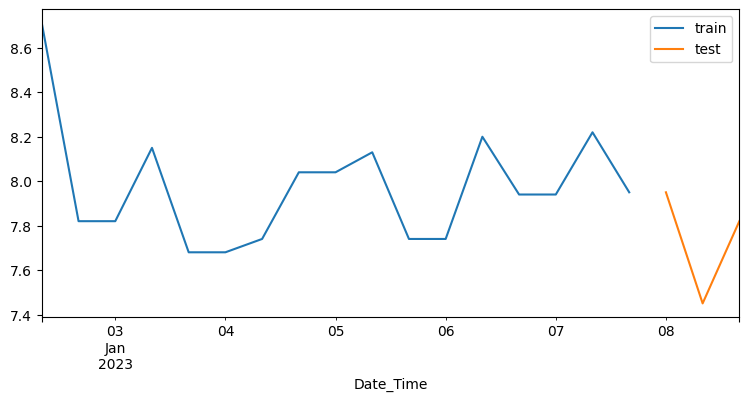

In [15]:
# Split data into train-test
# ==============================================================================
steps = 3
data_train = df[:-steps]
data_test  = df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['Vol Conventinal solar panel'].plot(ax=ax, label='train')
data_test['Vol Conventinal solar panel'].plot(ax=ax, label='test')
ax.legend();

In [16]:
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123,n_estimators= 100,
              max_depth=  10),
                lags = 4
             )

forecaster.fit(y=data_train['Vol Coated Sisal + Jute'])

In [17]:
steps = 3
predictions = forecaster.predict(steps=steps)
predictions

2023-01-08 00:00:00    7.9430
2023-01-08 08:00:00    8.0371
2023-01-08 16:00:00    8.0064
Freq: 8H, Name: pred, dtype: float64

In [18]:
df.columns

Index(['Vol Conventinal solar panel', 'Vol Pure Sisal', 'Vol Sisal + Jute',
       'Vol Coated sisal', 'Vol Coated Sisal + Jute'],
      dtype='object')

In [19]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['Vol Coated Sisal + Jute'],
                y_pred = predictions
            )

print(f"MSE Error of Vol Coated Sisal + Jute' : {error_mse}")

MSE Error of Vol Coated Sisal + Jute' : 0.10094678999999933


In [20]:
def voltage_prediction(df,column_predict,steps):
    df = df.rename(columns={column_predict: 'y'})
    forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123,n_estimators= 100,
              max_depth=  10),
                lags = 4
             )

    forecaster.fit(y=df['y'])
    predictions = forecaster.predict(steps=steps)
    return predictions

    

In [21]:
df.columns

Index(['Vol Conventinal solar panel', 'Vol Pure Sisal', 'Vol Sisal + Jute',
       'Vol Coated sisal', 'Vol Coated Sisal + Jute'],
      dtype='object')

In [22]:
predictions = voltage_prediction(df,'Vol Coated Sisal + Jute',15)

In [24]:
predictions

2023-01-09 00:00:00    8.0351
2023-01-09 08:00:00    8.1071
2023-01-09 16:00:00    8.1537
2023-01-10 00:00:00    8.1482
2023-01-10 08:00:00    8.0628
2023-01-10 16:00:00    7.8775
2023-01-11 00:00:00    7.8035
2023-01-11 08:00:00    7.9525
2023-01-11 16:00:00    8.1014
2023-01-12 00:00:00    8.1481
2023-01-12 08:00:00    8.1790
2023-01-12 16:00:00    8.1506
2023-01-13 00:00:00    7.8999
2023-01-13 08:00:00    7.9413
2023-01-13 16:00:00    7.7897
Freq: 8H, Name: pred, dtype: float64

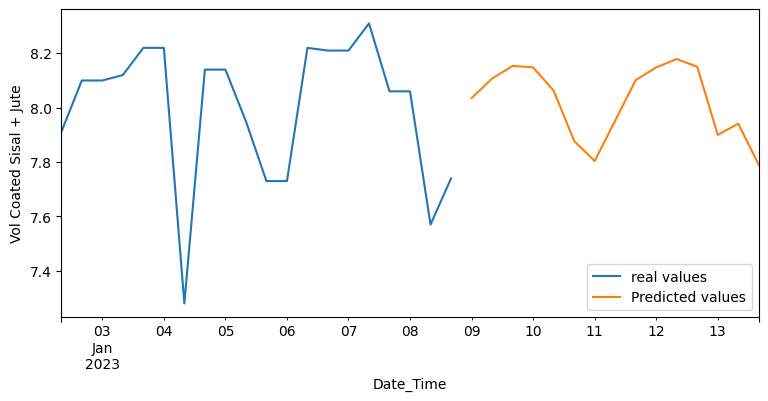

In [23]:
# Split data into train-test
# ==============================================================================


fig, ax=plt.subplots(figsize=(9, 4))
df['Vol Coated Sisal + Jute'].plot(ax=ax, label='real values')
predictions.plot(ax=ax, label='Predicted values')
plt.ylabel('Vol Coated Sisal + Jute')
ax.legend();